<a href="https://colab.research.google.com/github/itsclint/Recipt_OCR/blob/main/Notebooks/Receipt_OCR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install pytesseract

In [ ]:
import numpy as np 
import cv2
import matplotlib.pyplot as plt
import pytesseract


from skimage.filters import threshold_local
from PIL import Image
from pytesseract import Output

In [ ]:
def opencv_resize(image, ratio):
  width = int(image.shape[1] * ratio)
  height = int(image.shape[0] * ratio)
  dim = (width, height)
  return cv2.resize(image, dim, interpolation = cv2.INTER_AREA)


def plot_rgb(image):
  plt.figure(figsize=(16,10))
  return plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  

def plot_gray(image):
  plt.figure(figsize=(16,10))
  return plt.imshow(image, cmap='Greys_r')

In [ ]:
img = '/content/1099-receipt.jpg'
image = cv2.imread(img)

resize_ratio = 500 / image.shape[0]
original = image.copy()
image = opencv_resize(image, resize_ratio)

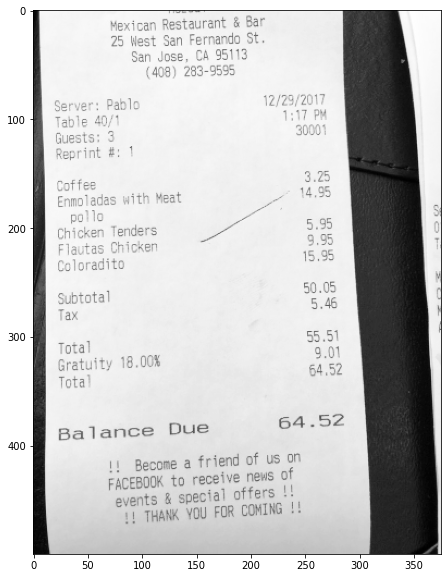

In [ ]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plot_gray(gray)

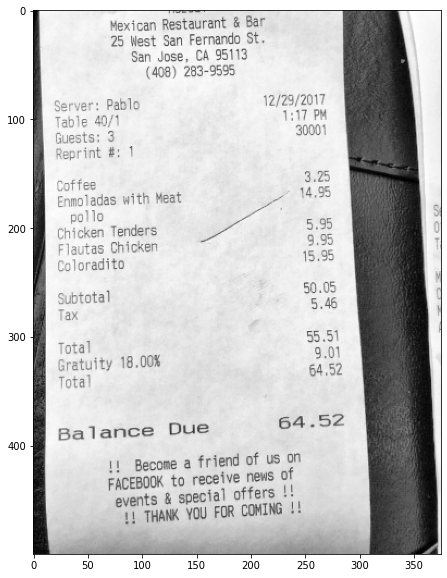

In [ ]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
cleimg = clahe.apply(gray)
plot_gray(cleimg)

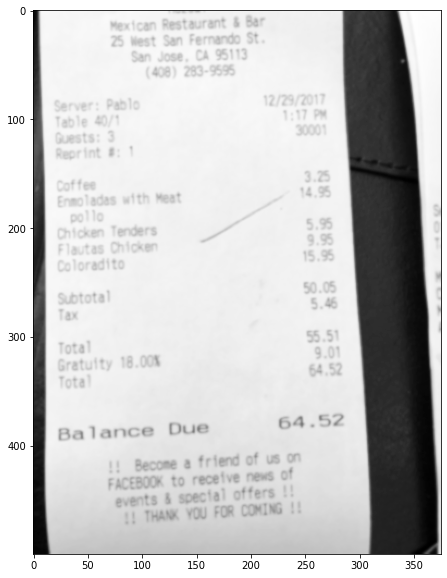

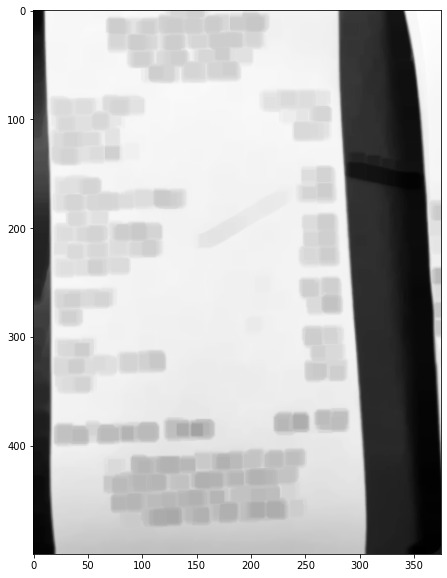

In [ ]:
#Get rid of noise with Gaussian Blur filter
blurred = cv2.GaussianBlur(gray, (5, 5), 1)
plot_gray(blurred)
blurred = cv2.medianBlur(blurred,7)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (10, 10))
erosion = cv2.erode(blurred,kernel,iterations = 1)
plot_gray(erosion)

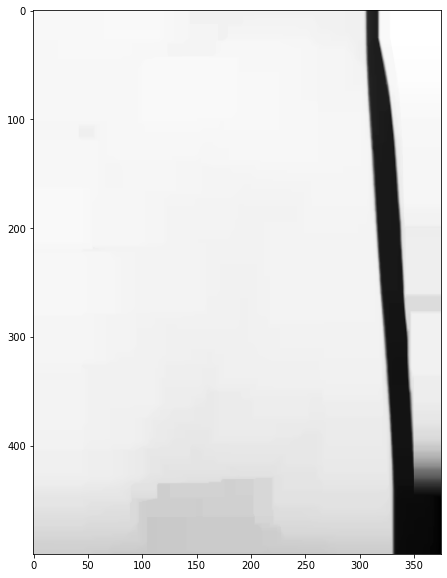

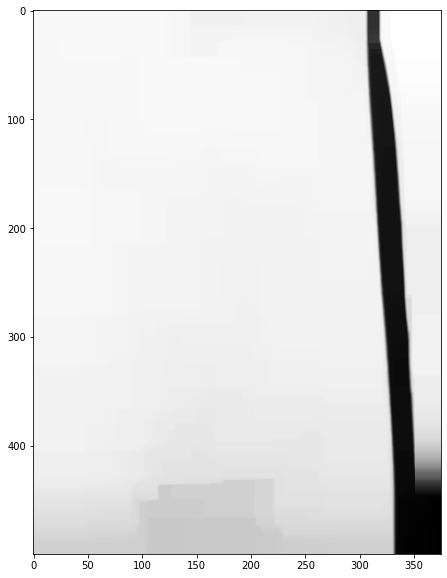

In [ ]:
# Detect white regions
rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (50, 50))
rectKernel2 = cv2.getStructuringElement(cv2.MORPH_RECT, (10, 20))
dilated = cv2.dilate(erosion, rectKernel)
plot_gray(dilated)

opening = cv2.morphologyEx(dilated, cv2.MORPH_OPEN, rectKernel2)
closing = cv2.morphologyEx(dilated, cv2.MORPH_CLOSE, rectKernel2)

plot_gray(closing)

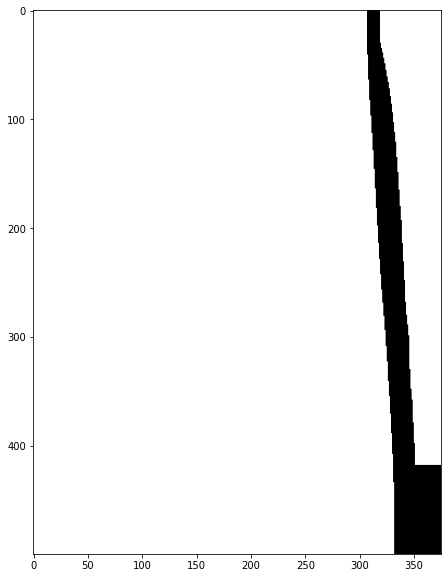

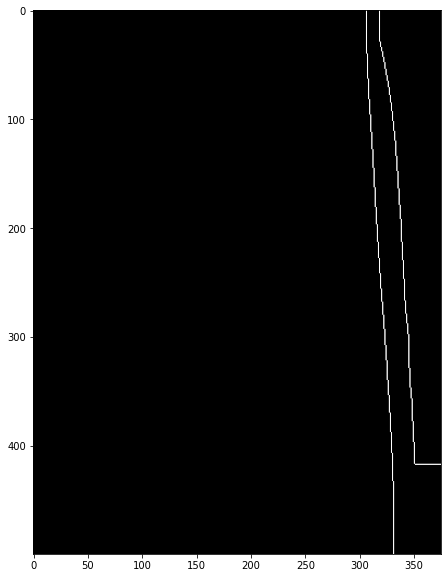

In [ ]:
(thresh, blackAndWhiteImage) = cv2.threshold(closing, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
plot_gray(blackAndWhiteImage)

edged = cv2.Canny(blackAndWhiteImage, 30, 30, apertureSize=3)
plot_gray(edged)

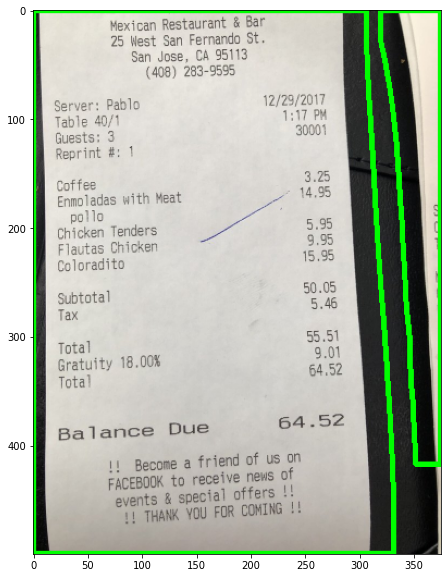

In [ ]:
# Detect all contours in Canny-edged image
contours, hierarchy = cv2.findContours(blackAndWhiteImage, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
image_with_contours = cv2.drawContours(image.copy(), contours, -1, (0,255,0), 3)
plot_rgb(image_with_contours)

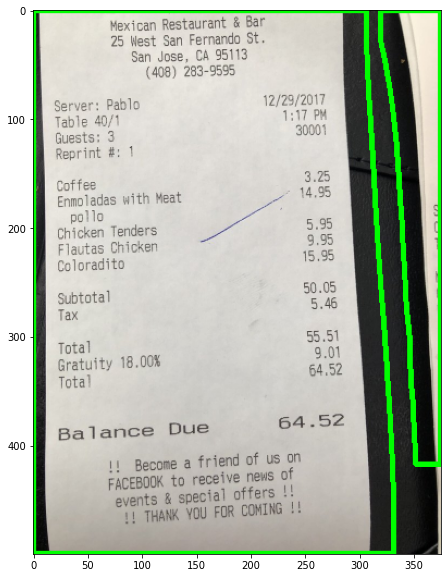

In [ ]:
# Get 10 largest contours
largest_contours = sorted(contours, key = cv2.contourArea, reverse = True)[:10]
image_with_largest_contours = cv2.drawContours(image.copy(), largest_contours, -1, (0,255,0), 3)
plot_rgb(image_with_largest_contours)

In [ ]:
# approximate the contour by a more primitive polygon shape
def approximate_contour(contour):
    peri = cv2.arcLength(contour, True)
    return cv2.approxPolyDP(contour, 0.032 * peri, True)

In [ ]:
def get_receipt_contour(contours):    
    # loop over the contours
    for c in contours:
        approx = approximate_contour(c)
        # if our approximated contour has four points, we can assume it is receipt's rectangle
        if len(approx) == 4:
            return approx

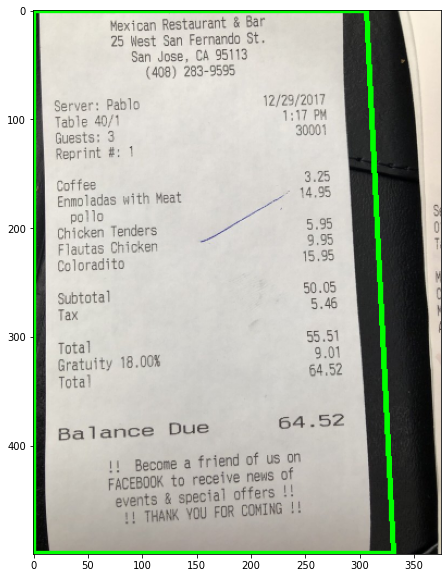

In [ ]:
receipt_contour = get_receipt_contour(largest_contours)
image_with_receipt_contour = cv2.drawContours(image.copy(), [receipt_contour], -1, (0, 255, 0), 3)
plot_rgb(image_with_receipt_contour)

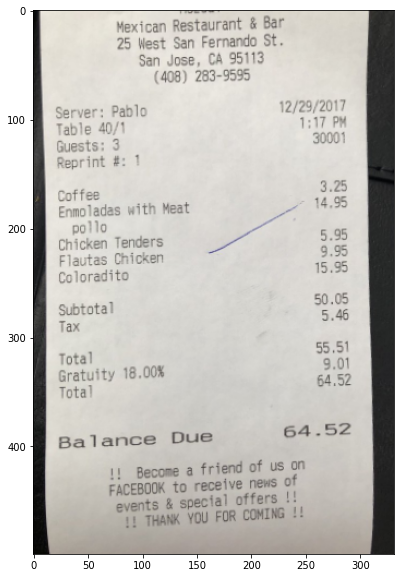

In [ ]:
def persp_transform(img, s_points):
    """ Transform perspective from start points to target points """
    # Euclidean distance - calculate maximum height and width
    height = max(np.linalg.norm(s_points[0] - s_points[1]),
                 np.linalg.norm(s_points[2] - s_points[3]))
    width = max(np.linalg.norm(s_points[1] - s_points[2]),
                 np.linalg.norm(s_points[3] - s_points[0]))
    
    # Create target points
    t_points = np.array([[0, 0],
                        [0, height],
                        [width, height],
                        [width, 0]], np.float32)
    
    # getPerspectiveTransform() needs float32
    if s_points.dtype != np.float32:
        s_points = s_points.astype(np.float32)
    
    M = cv2.getPerspectiveTransform(s_points, t_points) 
    return cv2.warpPerspective(img, M, (int(width), int(height)))
    
    
newImage = persp_transform(image, receipt_contour)
plot_rgb(newImage)

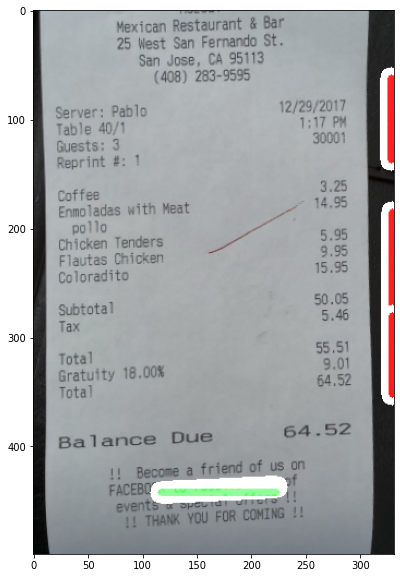

In [ ]:
temp_image = cv2.cvtColor(newImage.copy(), cv2.COLOR_BGR2RGB)


blurred = cv2.GaussianBlur(temp_image, (5, 5), 1)

blurred = cv2.medianBlur(blurred,7)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (10, 10))
erosion = cv2.erode(blurred,kernel,iterations = 1)



# Detect white regions
rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (50, 50))
rectKernel2 = cv2.getStructuringElement(cv2.MORPH_RECT, (10, 20))
dilated = cv2.dilate(erosion, rectKernel)


opening = cv2.morphologyEx(dilated, cv2.MORPH_OPEN, rectKernel2)
closing = cv2.morphologyEx(dilated, cv2.MORPH_CLOSE, rectKernel2)

edged = cv2.Canny(opening, 30, 30, apertureSize=3)

rho = 1  # distance resolution in pixels of the Hough grid
theta = np.pi / 600  # angular resolution in radians of the Hough grid
threshold = 10  # minimum number of votes (intersections in Hough grid cell)
min_line_length = 50  # minimum number of pixels making up a line
max_line_gap = 20  # maximum gap in pixels between connectable line segments

line_image = np.copy(temp_image) * 0  # creating a blank to draw lines on

minLineLength = 100
maxLineGap = 10
lines = cv2.HoughLinesP(edged, rho, theta, threshold, np.array([]),
                    min_line_length, max_line_gap)
for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(line_image,(x1,y1),(x2,y2),(255,255,255),20)
        diff_x = abs(x1 - x2)
        diff_y = abs(y1 - y2)
        if(diff_y <= diff_x):
            cv2.line(line_image,(x1,y1),(x2,y1),(0,255,0),5)
        else:
            cv2.line(line_image,(x1,y1),(x1,y2),(0,0,255),5)

            #cv2.putText(temp_image, str(diff_x) + ' | ' + str(diff_y), (x1,y1), cv2.FONT_HERSHEY_SIMPLEX, 3, (255, 10, 100), 2, cv2.LINE_AA)
        

lines_edges = cv2.addWeighted(temp_image, 0.8, line_image, 1, 0)


plot_rgb(lines_edges)

In [ ]:
def bw_scanner(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    T = threshold_local(gray, 21, offset = 5, method = "gaussian")
    return (gray > T).astype("uint8") * 25

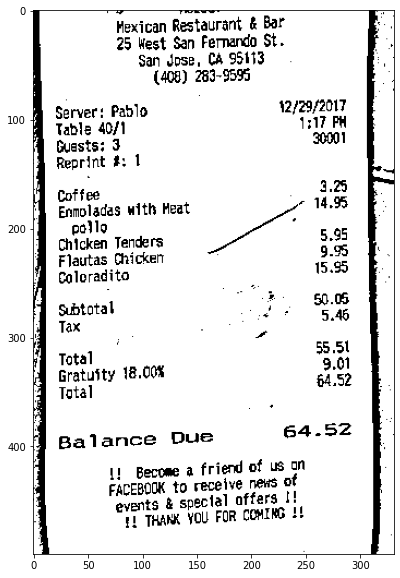

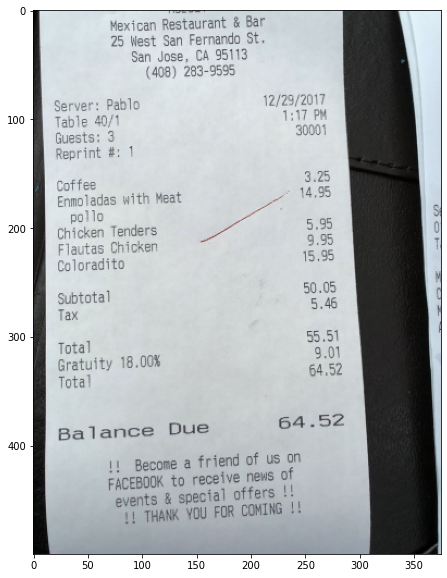

In [ ]:
result = bw_scanner(newImage)
plot_gray(result)
plot_gray(image)

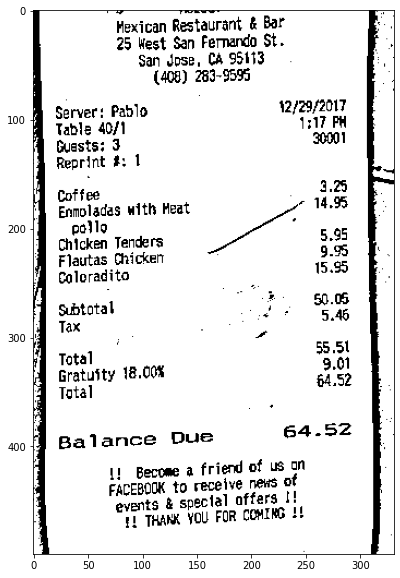

In [ ]:
plot_gray(result)

In [ ]:
!sudo apt install tesseract-ocr

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
0 upgraded, 0 newly installed, 0 to remove and 31 not upgraded.


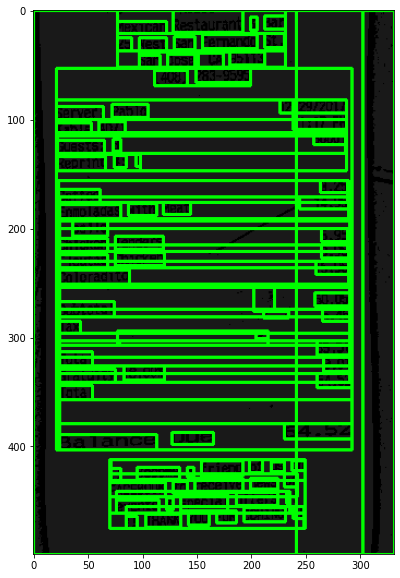

In [ ]:
d = pytesseract.image_to_data(result, output_type=Output.DICT)
n_boxes = len(d['level'])
boxes = cv2.cvtColor(result.copy(), cv2.COLOR_BGR2RGB)
for i in range(n_boxes):
    (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])    
    boxes = cv2.rectangle(boxes, (x, y), (x + w, y + h), (0, 255, 0), 2)
    
plot_rgb(boxes)

In [ ]:
extracted_text = pytesseract.image_to_string(result)
print(extracted_text)

Fexican Restaurant & Bar
3 kest San Fernando St.
San dose, Ch 95113

(408) 283-9595

Server: Pablo 42/29/2017
Table 40/1 ere
Cussts: 3 30001
Reprint #: 1

Coffee 3.25
Ennoladas with Heat 614.55

patlo
Chicken Tenders 5.95
Flautas Chicken 9.5
Coloradito 5.5
subtotal of 60.06
Tax 4 5a
: -

Total 55.51
Gratusty 18.00% 9.01
Total $452
Balance Due 64.52

1! Becone a friend of us on
FACEBOOK to receive news of
events & spectal offers !

tL THANK YOU FOR COMING 1

  

 

